# Bird Call Classification

## Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal, stats

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline

from tslearn.svm import TimeSeriesSVC

import os
import sys
import h5py
import warnings
warnings.filterwarnings("ignore")

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Load Data

In [2]:
data_root = os.path.join('..', '..', 'data', 'anesthetized')
data_root

'..\\..\\data\\anesthetized'

In [3]:
df = pd.read_csv('aa-4.csv')
df.sample(n=5)

,subject,site,single_unit,sortType,stim_number,original_wavfile,callerAge,callid,stim_duration,stim_source,stim_source_sex,stim_type,brain_region,hemisphere,vocid,auditory_cortex
773,BlaBro09xxF,Site1,Site1_L1500R1500_e15_s0_ss1,single,275,WhiLbl0010_MAS_So_1.wav,NaN,NaN,2.647866,unfamiliar,m,song,L1,L,song,A1
71787,WhiWhi4522M,Site4,Site4_L2100R2050_e29_s0_ss1,single,51,BlaBla0506_MAF_Te_5-6-10.wav,A,Te,2.500000,familiar,m,call,L2A,R,Te,A1
61922,WhiWhi4522M,Site3,Site3_L1900R1800_e16_s0_ss2,single,133,BluRas07dd_FAS_Te_2-7-9.wav,A,Te,2.500000,unfamiliar,f,call,L2A,L,Te,A1
79825,YelBlu6903F,Site2,Site2_L1000R900_e10_s0_ss2,single,92,STRFxx0000__So_4.wav,NaN,NaN,2.003031,unfamiliar,m,song,NCM,L,song,A2
84692,YelBlu6903F,Site2,Site2_L1000R900_e28_s0_ss2,single,80,STRFxx0000__So_11.wav,NaN,NaN,2.090030,unfamiliar,m,song,L2B,R,song,A1


In [4]:
df.isnull().sum()/len(df)

subject             0.000000
site                0.000000
single_unit         0.000000
sortType            0.000000
stim_number         0.000000
original_wavfile    0.000000
callerAge           0.222987
callid              0.222987
stim_duration       0.000000
stim_source         0.000000
stim_source_sex     0.000000
stim_type           0.000000
brain_region        0.000000
hemisphere          0.000000
vocid               0.000000
auditory_cortex     0.000000
dtype: float64

## Utility Functions

In [5]:
# returns a matrix of shape (n_trials, n_neurons).
def getPopulationResponse(bird, stim_number, hemisphere='L', site='Site1'):
    resp_df = df[(df['subject']==bird) & (df['stim_number']==stim_number) & (df['hemisphere']==hemisphere) & (df['site']==site)]
    
    # load data
    cells = resp_df['single_unit'].unique()
    population_response = []
    
    # cell == neuron
    for cell in cells:
        # load cell
        source_path = os.path.join(data_root, bird, cell+'.h5')
        neuron_data = h5py.File(source_path)
        main_key = [k for k in neuron_data.keys() if k.__contains__('Call')][0]
        
        # load response
        cell_response = []
        trialIDs = neuron_data[main_key][str(stim_number)].keys()
        for trialID in trialIDs:
            trial_response = neuron_data[main_key][str(stim_number)][trialID]['spike_times'][:]
            cell_response.append(trial_response)
        
        population_response.append(cell_response)
    population_response = np.array(population_response)
    return np.swapaxes(population_response, 0, 1)    # since neuron is in the outer loop, original shape is (n_neurons, n_trials)

response = getPopulationResponse('GreBlu9508M', stim_number=50)
response.shape

(10, 16)

In [6]:
# returns a matrix of shape (n_trials, n_neurons, n_timesteps)
def times2trains(population_response, start=0, end=450):
    trial_count = population_response.shape[0]
    neuron_count = population_response.shape[1]
    
    spike_trains = np.zeros((trial_count, neuron_count, 450))
    for i, trial in enumerate(population_response):
        for j, neuron in enumerate(trial):
            for k, time in enumerate(neuron):
                if time >= -999:    # NaNs are stored as -999 in the data
                    time = np.clip(time, -1, 3.490)
                    spike_trains[i, j, 100+int(np.round(time*100))] += 1
    return spike_trains[:, :, start:end]

spike_trains = times2trains(response, start=100, end=350)
spike_trains.shape

(10, 16, 250)

Text(0.5, 1.0, 'Spike Raster Plot')

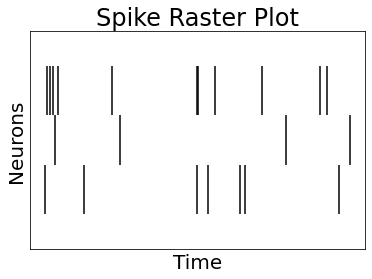

In [7]:
plt.eventplot([np.nonzero(spike_trains[0, 11])[0], np.nonzero(spike_trains[0, 13])[0], np.nonzero(spike_trains[0, 3])[0]], color='k')
plt.xticks([])
plt.yticks([])
plt.xlabel('Time', fontsize=20)
plt.ylabel('Neurons', fontsize=20)
plt.title('Spike Raster Plot', fontsize=24)

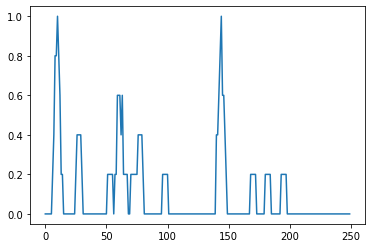

In [8]:
# expects input shape (n_trials, n_neurons, n_timesteps)
def trains2rates(spike_trains):
    firing_rates = np.zeros(spike_trains.shape)
    window = signal.windows.boxcar(5)
    window = window / np.sum(window)
    
    for i, trial in enumerate(spike_trains):
        for j, neuron_response in enumerate(trial):
            firing_rates[i][j] = signal.convolve(neuron_response, window, mode='same') / sum(window)
    return firing_rates

firing_rates = trains2rates(spike_trains)
plt.plot(firing_rates[0][0])

In [9]:
firing_rates.shape

(10, 16, 250)

In [10]:
# returns a matrix X of shape (n_callids, n_timesteps, n_dimensions)
def getClassificationDataset(bird, hemisphere='L', auditory_cortex='A2', n_neurons=None):
    resp_df = df[(df['subject']==bird) & (df['hemisphere']==hemisphere) & (df['auditory_cortex']==auditory_cortex)]

    # load data
    cells = resp_df['single_unit'].unique()
    callids = resp_df['callid'].unique()
    X, y = [], []
    
    if n_neurons is not None:
        rng = np.random.default_rng()
        cells = rng.choice(cells, size=n_neurons, replace=False)
    
    for callid in callids:
        
        stimuli = resp_df[resp_df['callid']==callid]['stim_number'].unique()
        for stimulus in stimuli:
            stimulus_response = []
            duration = int(resp_df[resp_df['stim_number']==stimulus]['stim_duration'].mean() * 100)
            
            for cell in cells:
                # load cell
                source_path = os.path.join(data_root, bird, cell+'.h5')
                neuron_data = h5py.File(source_path)
                main_key = [k for k in neuron_data.keys() if k.__contains__('Call')][0]

                # load response
                cell_response = []
                try:
                    trialIDs = neuron_data[main_key][str(stimulus)].keys()
                except:
                    continue
                for i, trialID in enumerate(trialIDs):
                    if i>9:
                        break
                    trial_response = neuron_data[main_key][str(stimulus)][trialID]['spike_times'][:]
                    cell_response.append(trial_response)

                # cell_response shape: (n_trials[, times]) because no. of spike times are variable
                cell_response = np.expand_dims(np.array(cell_response), axis=1)    # insert neuron axis at pos. 1
                # cell_response shape: (n_trials, 1[, times])
                cell_response = times2trains(cell_response, start=100, end=350)
                # cell_response shape: (n_trials, 1, n_timesteps)
                cell_response = trains2rates(cell_response)
                # cell_response shape: (n_trials, 1, n_timesteps)
                cell_response = np.mean(cell_response, axis=0)    # average across trials    WHY? because cells heard the sound at diff times.
                # cell_response shape: (1, n_timesteps)
                cell_response = np.squeeze(cell_response).tolist()
                # cell_response shape: (n_timesteps)

                stimulus_response.append(cell_response)
            
            #print('stim resp: ', len(stimulus_response))
            if len(stimulus_response) == n_neurons:    
                X.append(stimulus_response)
                y.append(callid)
    X, y = np.array(X), np.array(y)
    # X shape: (n_callids, n_dimensions, n_timesteps)
    X = np.swapaxes(X, 1, 2)    
    # X shape: (n_callids, n_timesteps, n_dimensions)
    return X, y

In [11]:
def getDimensionality(explained_variance_ratio_):
    cumsum = np.cumsum(explained_variance_ratio_)
    dim = np.searchsorted(cumsum, 0.8) + 1
    return dim

## Classification: A1 vs A2

In [14]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import normalize

def cross_validate(X, y):
    scores = []
    for _ in range(3):
        n_samples, n_timesteps, n_neurons = X.shape
        X_train, X_test, y_train, y_test = train_test_split(np.reshape(X, (n_samples, -1)), y, test_size=0.33)

        lda = LinearDiscriminantAnalysis()

        X_train = np.reshape(X_train, (-1, n_timesteps, n_neurons))
        n_samples_train = X_train.shape[0]

        X_timepoints_by_neurons_train = np.reshape(X_train, (-1, n_neurons))
        y_timepoints_train = np.repeat(y_train, n_timesteps)
        #X_timepoints_by_neurons_train = normalize(X_timepoints_by_neurons_train, axis=0)    # axis=0 to normalize features

        X_transformed_train = lda.fit_transform(X_timepoints_by_neurons_train, y_timepoints_train)
        n_dimensions_train = X_transformed_train.shape[1]
        X_transformed_train = np.reshape(X_transformed_train, (n_samples_train, n_timesteps, n_dimensions_train))

        clf = TimeSeriesSVC(C=10, kernel="linear")
        clf.fit(X_transformed_train, y_train)

        X_test = np.reshape(X_test, (-1, n_timesteps, n_neurons))
        n_samples_test = X_test.shape[0]

        X_timepoints_by_neurons_test = np.reshape(X_test, (-1, n_neurons))
        y_timepoints_test = np.repeat(y_test, n_timesteps)
        #X_timepoints_by_neurons_test = normalize(X_timepoints_by_neurons_test, axis=0)    # axis=0 to normalize features

        X_transformed_test = lda.transform(X_timepoints_by_neurons_test)
        n_dimensions_test = X_transformed_test.shape[1]
        X_transformed_test = np.reshape(X_transformed_test, (n_samples_test, n_timesteps, n_dimensions_test))

        scores.append(clf.score(X_transformed_test, y_test))
    
    return np.mean(scores)


In [15]:
subject_table = df[['subject', 'hemisphere']].drop_duplicates()
subject_table

subject_table = subject_table.reset_index()  # make sure indexes pair with number of rows

list_dict = []
for i, row in subject_table.iterrows():
    a1_neurons = len(df[(df['subject']==row['subject'])&(df['hemisphere']==row['hemisphere'])&(df['auditory_cortex']=='A1')]['single_unit'].unique())
    a2_neurons = len(df[(df['subject']==row['subject'])&(df['hemisphere']==row['hemisphere'])&(df['auditory_cortex']=='A2')]['single_unit'].unique())
    neuron_count = a1_neurons if a1_neurons < a2_neurons else a2_neurons
    a1_dims, a2_dims = [], []
    data_dict = {
        'subject': row['subject'],
        'hemisphere': row['hemisphere'],
        'a1_neurons': a1_neurons,
        'a2_neurons': a2_neurons,
        'neuron_count': neuron_count
    }
    print(data_dict)
    
    if neuron_count == 0:
        continue
    
    if abs(a2_neurons - a1_neurons) < 5: 
        loops = 1
    else:
        loops = 100
        
    a1_scores = []
    # in every iteration, we get a random selection of neurons
    a1_loops = loops if a1_neurons > a2_neurons else 1
    for i in range(a1_loops):
        X, y = getClassificationDataset(data_dict['subject'], data_dict['hemisphere'], 'A1', neuron_count)

        # cross validate
        score = cross_validate(X, y)
        a1_scores.append(score)

    a2_scores = []
    # in every iteration, we get a random selection of neurons
    a2_loops = loops if a2_neurons > a1_neurons else 1
    for j in range(a2_loops):
        X, y = getClassificationDataset(data_dict['subject'], data_dict['hemisphere'], 'A2', neuron_count)
        
        # cross validate
        score = cross_validate(X, y)
        a2_scores.append(score)

        
    data_dict['clf_a1'] = np.mean(a1_scores)
    data_dict['std_a1'] = np.std(a1_scores)
    data_dict['clf_a2'] = np.mean(a2_scores)
    data_dict['std_a2'] = np.std(a2_scores)
    data_dict['pvalue_ranksum'] = stats.ranksums(a2_scores, a1_scores)[1] / 2    # div. by 2 because this is two-sided pvalue. upgrading to latest scipy breaks tslearn
    list_dict.append(data_dict)
    print(pd.DataFrame(list_dict))

print('done')

{'subject': 'BlaBro09xxF', 'hemisphere': 'L', 'a1_neurons': 8, 'a2_neurons': 43, 'neuron_count': 8}
       subject hemisphere  a1_neurons  a2_neurons  neuron_count    clf_a1  \
0  BlaBro09xxF          L           8          43             8  0.376344   

   std_a1    clf_a2    std_a2  pvalue_ranksum  
0     0.0  0.268817  0.048882        0.089856  
{'subject': 'BlaBro09xxF', 'hemisphere': 'R', 'a1_neurons': 60, 'a2_neurons': 20, 'neuron_count': 20}
       subject hemisphere  a1_neurons  a2_neurons  neuron_count    clf_a1  \
0  BlaBro09xxF          L           8          43             8  0.376344   
1  BlaBro09xxF          R          60          20            20  0.379928   

     std_a1    clf_a2    std_a2  pvalue_ranksum  
0  0.000000  0.268817  0.048882        0.089856  
1  0.030833  0.440860  0.000000        0.089856  
{'subject': 'GreBlu9508M', 'hemisphere': 'L', 'a1_neurons': 57, 'a2_neurons': 58, 'neuron_count': 57}
       subject hemisphere  a1_neurons  a2_neurons  neuron_count

In [18]:
clf_df = pd.DataFrame(list_dict)
clf_df = clf_df.dropna()
clf_df

,subject,hemisphere,a1_neurons,a2_neurons,neuron_count,clf_a1,std_a1,clf_a2,std_a2,pvalue_ranksum
0,BlaBro09xxF,L,8,43,8,0.376344,0.000000,0.268817,0.048882,0.089856
1,BlaBro09xxF,R,60,20,20,0.379928,0.030833,0.440860,0.000000,0.089856
2,GreBlu9508M,L,57,58,57,0.612903,0.000000,0.741935,0.000000,0.158655
3,GreBlu9508M,R,76,74,74,0.548387,0.000000,0.806452,0.000000,0.158655
4,LblBlu2028M,R,4,25,4,0.351852,0.000000,0.395062,0.008730,0.089856
5,WhiWhi4522M,L,9,64,9,0.408602,0.000000,0.412186,0.105476,0.327360
6,WhiWhi4522M,R,58,54,54,0.731183,0.000000,0.752688,0.000000,0.158655
7,YelBlu6903F,L,40,84,40,0.666667,0.000000,0.738351,0.013411,0.089856
8,YelBlu6903F,R,36,81,36,0.526882,0.000000,0.670251,0.050689,0.089856


In [20]:
stats.wilcoxon(clf_df['clf_a2'], clf_df['clf_a1'], alternative='greater', nan_policy='omit')

WilcoxonResult(statistic=39.0, pvalue=0.02734375)

In [21]:
stats.wilcoxon(clf_df[clf_df['neuron_count'] > 20]['clf_a2'], clf_df[clf_df['neuron_count'] > 20]['clf_a1'], alternative='greater', nan_policy='omit')

WilcoxonResult(statistic=15.0, pvalue=0.03125)

In [38]:
stats.wilcoxon(clf_df['clf_a2'], clf_df['clf_a1'], alternative='greater', nan_policy='omit')

WilcoxonResult(statistic=37.0, pvalue=0.048828125)

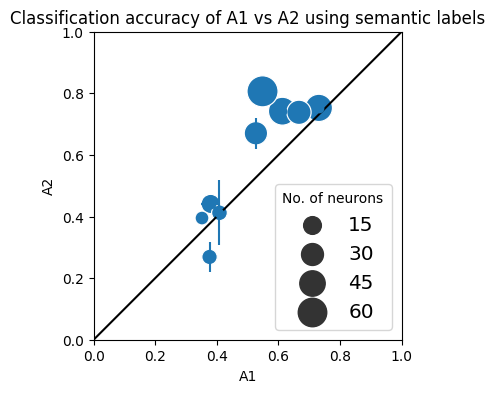

In [22]:
import seaborn as sns
plt.style.use('default')
plt.figure(figsize=(4, 4))
g = sns.scatterplot(x='clf_a1', y='clf_a2', data=clf_df, size='neuron_count', sizes=(100, 500), palette='YlOrRd')
plt.errorbar(clf_df['clf_a1'], clf_df['clf_a2'], xerr=clf_df['std_a1'], yerr=clf_df['std_a2'], fmt="o")
plt.axline((0, 0), (1, 1), color='black')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.draw()

plt.xlabel('A1')
plt.ylabel('A2')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('Classification accuracy of A1 vs A2 using semantic labels')
#plt.title('using semantic labels')
#plt.title('Classification accuracy of A1 vs A2')
plt.legend(title='No. of neurons', loc='lower right', fontsize='x-large')
plt.savefig('clf-acc.png')
plt.show(g)

In [23]:
stats.pearsonr(clf_df['clf_a2'] - clf_df['clf_a1'], clf_df['neuron_count'])

PearsonRResult(statistic=0.7509191593754835, pvalue=0.019705994647604162)